# Automatic Speech Recognition and Diarization

This notebook relies on Hugging Face for automatic speech recognition. For Diarization, we use a combination of Hugging Face and PyAnnote. The notebook uses OpenAI's Whisper model.

## Installing prerequisites
This can take a little while....

In [2]:
!pip install --upgrade pip -q
!pip install --upgrade git+https://github.com/huggingface/transformers.git accelerate datasets[audio] -q
!pip install evaluate jiwer -q
!pip install --upgrade pyannote.audio -q
!pip install git+https://github.com/huggingface/speechbox -q
print('-----------')
print('I\'m ready')

^C
zsh:1: no matches found: datasets[audio]
^C
^C
^C
-----------
I'm ready


In [1]:
import glob
from IPython.display import Audio as playaudio
from IPython.display import HTML, display
from pathlib import Path
import pandas as pd
import torch
from evaluate import load
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import Audio, load_dataset, Dataset
from tqdm import tqdm
import google.colab
from google.colab import drive
from transformers.pipelines.pt_utils import KeyDataset
from pyannote.audio import Pipeline
import torchaudio
from speechbox import ASRDiarizationPipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32



ModuleNotFoundError: No module named 'evaluate'

## Helper Functions

In [ ]:
def set_css():
  '''
  this enables line wrapping in google colab output
  '''

  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)


def get_matching_audio_file_name(transcription_file_name):
  '''
  This function matches the file names of the audio files with those of the transcriptions.
  This is only needed for liederenbank
  '''
  # Split the name on underscore and take the first part
  return transcription_file_name.split('_')[0]

def tuple_to_string(start_end_tuple, ndigits=1):
    return str((round(start_end_tuple[0], ndigits), round(start_end_tuple[1], ndigits)))


def format_as_transcription(raw_segments):
  '''
  This prettifies the diarization output
  '''
  return "\n\n".join(
      [
          chunk["speaker"] + " " + tuple_to_string(chunk["timestamp"]) + chunk["text"]
          for chunk in raw_segments
      ]
  )

## File management.

We will use google drive for file storage. You need to give Colab access to Google Drive.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare dataset
Here we prepare our data in the correct `Datasets` format for Hugging Face to use it

### Construct metadata file

You only have to do this once, but it's ok if you run it again.

In [ ]:
# todo: skip if metadata.csv exists

project = 'liederenbank' # liederenbank or vvb
folder_path = Path(f'/content/drive/MyDrive/Work/Meertens/{project}') #change to your own path.

audio_files = {file.stem: file for file in folder_path.glob('data/*.mp3')} # this assumes we have mp3, if wave change to .wav
transcription_files = folder_path.glob('data/*.txt')

data = []
for transcription_file in transcription_files:
  if project == 'liederenbank':
    modified_stem = get_matching_audio_file_name(transcription_file.stem)
    audio_file = audio_files.get(modified_stem)
  else:
    audio_file = audio_files.get(transcription_file.stem)

  if audio_file:
    try:
      with open(transcription_file, 'r', encoding='latin-1') as file: #check encoding
        print(transcription_file)
        transcription_content = file.read().strip()
      data.append({'file_name': str(audio_file.relative_to(folder_path)), 'transcription': transcription_content})
    except IOError as e:
      print(f"Error reading file {transcription_file}: {e}")

df = pd.DataFrame(data)
output_file = folder_path / 'metadata.csv'

with open(output_file, 'w', encoding='latin-1') as file:
    df.to_csv(file, index=False)


/content/drive/MyDrive/Work/Meertens/liederenbank/data/OGL08703_OGL_NLB70769.txt
/content/drive/MyDrive/Work/Meertens/liederenbank/data/OGL40109_OGL_NLB75377.txt
/content/drive/MyDrive/Work/Meertens/liederenbank/data/OGL34904_NLB74639.txt
/content/drive/MyDrive/Work/Meertens/liederenbank/data/OGL34408_NLB74602.txt
/content/drive/MyDrive/Work/Meertens/liederenbank/data/OGL33608_NLB74526.txt
/content/drive/MyDrive/Work/Meertens/liederenbank/data/OGL32116_NLB74301.txt
/content/drive/MyDrive/Work/Meertens/liederenbank/data/OGL29408_NLB73890.txt
/content/drive/MyDrive/Work/Meertens/liederenbank/data/OGL14103b_NLB71625.txt
/content/drive/MyDrive/Work/Meertens/liederenbank/data/OGL08404_NLB70741.txt
/content/drive/MyDrive/Work/Meertens/liederenbank/data/OGL22024_NLB72795.txt


## Prepare dataset
We will use the metadata.csv to construct a dataset in the Hugging Face Dataset format.

In [ ]:
dataset = load_dataset("audiofolder", data_dir=folder_path) # folder_path is defined in previous cell.

# we will change the sampling_rate from 44.1khz to 16khz
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
print(dataset["train"][0])

{'audio': {'path': '/content/drive/MyDrive/Work/Meertens/liederenbank/data/OGL08404.mp3', 'array': array([4.54570626e-12, 5.83542936e-12, 8.48808177e-12, ...,
       1.39551935e-06, 1.52508312e-06, 1.17711022e-06]), 'sampling_rate': 16000}, 'transcription': 'Wat hoort men toch in onze tijden \nVan gruwelen door des xxx veracht [?]\nVan daden die met gods woord strijden\nWandaden waar de hel om lacht\nDit nieuw gedicht dat gij hier hoort\nBehelst een vreselijke moord\nHet doet zien hoe door zucht [?] xxx naar geld\nEen offer wordt geveld.\n\nEen zeker heer te ’s Gravenhage\nLeefde met zijn vrouw en zoon\nNaar een ieders welbehagen\nOp een echte christentoon\nGeen wonder ja dan dat enigst kind\nDoor zijne ouders werd bemind\nEn toch zag men dat lieflijk span\nGeveld door moordenaarshand\n\nDit knaapje dat strakjes [?] moest sterven\nZonder angst kwam nare de school\nHet leren was zijn lust en leven\nHij was zeer vlijtig en vol jool.\nO arm schaap wist gij het maar\nDaarginder komt uw moo

## Load model
There are different models to chose from. We will now chose the largest (`large-v3`), which is faster than the v2 version. Smaller versions are faster but less accurate.

Options include:
- `tiny`
- `base`
- `small`
- `medium`
- `large`
- `large-v2`
- `large-v3`

In [ ]:
model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True,
)
model.to(device)

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bias=Tr

## Load Processing Pipeline

In [ ]:
processor = AutoProcessor.from_pretrained(model_id)

asr_pipeline = pipeline(
    "automatic-speech-recognition", # here we do ASR without translation,
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True, #this can also be set to False, if we don't want timestamps
    torch_dtype=torch_dtype,
    device=device,
)

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Demo

In [ ]:
sample_nr =

sample = dataset["train"][sample_nr]["audio"]
print(dataset["train"][sample_nr]["transcription"])
playaudio(sample["array"], rate=sample["sampling_rate"])

De klok der toren had negen geslagen
En 't knaapje spoedde zich naar school
Het leren was hem een behagen
het leren was hem een symbool
Ach, arm knaapje wist gij 't maar
Straks haalt u nog de moordenaar
Och, knaapjelief wist gij 't maar

De klok der toren had elf geslagen
Een rijtuig rolde de straten in
Een heer kwam aan de meester vragen
Of knaapje met hem mee mocht gaan
Men vroeg of hij die heer wel kon
Hij antwoordt "ja", voordat 'ie 't bezon,
En 't rijtuig rolt de straten voort
Langs bos en velden voort

De klok der toren had vijf geslagen
En de ouders werden zeer ongerust.
Zij deden bij 't gerecht toen vragen
Ze vreesden voor een ongeluk
Men zocht de hele stad in 't rond
Maar niemand die het knaapje vond
Maar niemand die 't knaapje vond

De klok der toren had elf geslagen
Toen er van verre kwam een brief
En aan de ouders het liet zeggen
Geef mij uw geld, zoveel ik beief
Al is de som u nog zo groot
Op duivelsberg breng ik hem ten dood
Dan breng ik hem daar ten dood

Zie hoe nu hier

In [ ]:
asr_pipeline(sample.copy())


{'text': " Wat hoort men toch in onze tijden, van gruwel en doordeut, uit ver aan. Vandaar de die men godswoord strijden, vandaar de waarde hel omlaag. Deze nieuwe gedicht dat je hier hoort behelst een vreselijke moord. Het doet zien hoe door ze komt naar gelden over voor het gevel. Een zeker heertes graven aan geliefde mensen, vrouw en zoon, naar een ieders wil behagen op een echte christenton. Wie wonderde ja dan dat een ons kind door zijn ouders werd bemin. En toch zag men dat liefdexpant geveld door de moeder naar zand. Dit knapje dat trakkend moest sterven viel viel zonder angst naar de school. Het leren was zijn lust en leven, hij was zeer vlijtig en vol jol. O, armschap, wist gij het maar, daar ginder komt uw moeder naar. Wie wil zo ooit een tederig knaap zo gij als ge op dit knaap? De klok, de stad, had vijf geslagen, toen een rij thuis stelen bleef staan. Voor de school een heren kwam vragen. Men toont het kind een vreemdeling aan. Maar vroeg al wij die heren welkom. Het kind 

In [ ]:
# you can also point directly to an .mp3
#pipe('/content/drive/MyDrive/Work/Meertens/vvb/data/VODA_004_19.mp3')

{'text': " Er was een torse daar op de plas. En toen kwam ook zo'n vrouw langs. En toen zei hij, hoe ga je ermee? Heb je veel koffie? Heb je veel roch? Bijna gek zit die boer zo, als we het koffie maar hebben. Maar ja, niks is koffie. Ja, geen roch."}

## Running batch prediction

Here we apply the pipeline to the entire dataset.
We produce a list called `all_predictions`

In [ ]:
all_predictions = []
for prediction in tqdm(
    asr_pipeline(
        KeyDataset(dataset['train'], "audio")
    ),
    total=len(dataset['train']),
):
    all_predictions.append(prediction["text"])


100%|██████████| 10/10 [01:44<00:00, 10.46s/it]


## Evaluation

Here we will evaluate our predictions by comparing them to our transcriptions. We will use Word Error Rate as a metric.

In [ ]:
from transformers.models.whisper.english_normalizer import BasicTextNormalizer
# this is a basic normalizer to remove punctuation and casing.

transcribed_texts = dataset['train']['transcription'] # we place all our transcriptions in a list.

normalizer = BasicTextNormalizer()
normalized_predictions = [normalizer(text) for text in all_predictions]
normalized_transcription = [normalizer(text) for text in transcribed_texts]


In [ ]:
metric = load("wer")
print(100 * metric.compute(references=normalized_transcription, predictions=normalized_predictions))

49.9507874015748


## Diarization

In [ ]:
from huggingface_hub import notebook_login

notebook_login()



In [ ]:
diarization_pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1", use_auth_token=True
)
diarization_pipeline.to(torch.device('cuda'))

config.yaml:   0%|          | 0.00/469 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.91M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/399 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/221 [00:00<?, ?B/s]

In [ ]:
# upload a file using widget
audio_file = list(google.colab.files.upload())[0]
audio_dataset = Dataset.from_dict({"audio": [audio_file]}).cast_column("audio", Audio())
result = asr_pipeline(audio_dataset[0]['audio'].copy(), generate_kwargs={"language": "dutch"})
print(result)

Saving VODA_037_01.mp3 to VODA_037_01.mp3
{'text': ' Mijn grootvader was er en hij had er weg gestaan en brood nog geen. Zo heeft het mij ook gebeurd, met mijn vader en brood nog geen. En toen kwam het ding, toen kwam het van Klooster aan en hij werd naar de schutten geweest en hij werd beschuldigd voor kruiden. Hij zei, Johannes, ik heb vandaag wat gezien, dat vergeer ik voor mijn hele leven niet. Mijn grootvader zei, maar wat heeft dat aan de zijne? Ja, dat was de omstreek, zou je zeggen, dat nu de weg is. Tussen de 3e en de 4e zeef. En er was een schip van het westen kwam zeilen en er was er zoveel omlangs gegaan. En er was tozen ingegaan. Ik ben op één knie gaan zitten en heb ernaar gekeken. Een schip met zeilen in mast, er was er zoveel wieg aan. Tozen ingegaan, dat was later nog. Was er nog zoveel bijzonders? Ja, maar toen was er nog geen wieg of niks. Toen was het later nog... Was er nog zoveel bijzonders? Ja, maar toen was er nog geen wijk of niks. Oh, was er geen wijk? Niks, n

In [ ]:
#waveform, sample_rate = torchaudio.load(audio_file) #preloading in memory for faster processing

In [ ]:
diarization = diarization_pipeline(audio_file, min_speakers=2, max_speakers=2)
diarization = diarization.rename_labels({"SPEAKER_00": "Interviewer", "SPEAKER_01": "Spreker"})

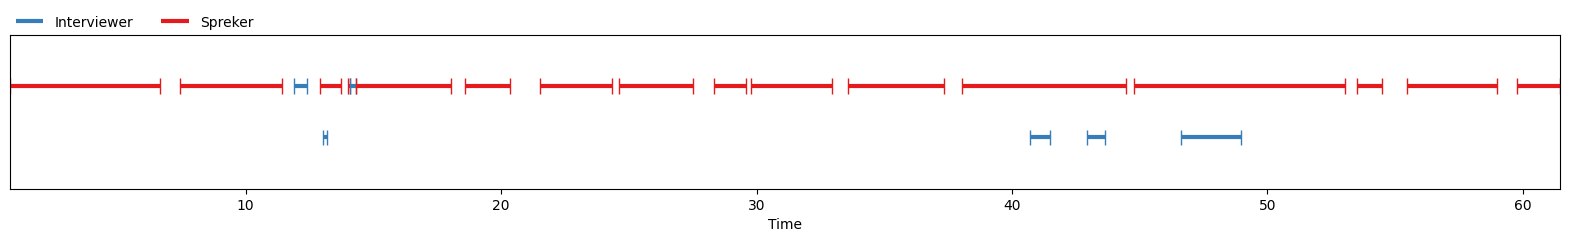

In [ ]:
diarization

In [ ]:
combined_pipeline = ASRDiarizationPipeline(
    asr_pipeline=asr_pipeline, diarization_pipeline=diarization_pipeline
)

In [ ]:
# @title
outputs = combined_pipeline(audio_dataset[0]['audio'].copy())

print(format_as_transcription(outputs))

SPEAKER_01 (0.0, 12.0) Mijn grootvader was er en hij had er weg gestaan en brood nog geen. Zo heeft het mij ook gebeurd, met mijn vader en brood nog geen. En toen kwam het ding, toen kwam het van Klooster aan en hij werd naar de schutten geweest en hij werd beschuldigd voor kruiden.

SPEAKER_00 (12.0, 18.0) Hij zei, Johannes, ik heb vandaag wat gezien, dat vergeer ik voor mijn hele leven niet.

SPEAKER_01 (18.0, 27.0) Mijn grootvader zei, maarks, dat nu de wieg is. Tussen de 3e en de 4e zeef.

SPEAKER_00 (27.0, 33.0) En er was een schip van het westen kwam zeilen en er was er zoveel omlangs gegaan.

SPEAKER_01 (33.0, 37.0) En er was tozen ingegaan. Ik ben op één knie gaan zitten en heb ernaar gekeken.

SPEAKER_00 (37.0, 40.0) Een schip met zeilen in mast, er was er zoveel wieg aan.

SPEAKER_01 (40.0, 46.0) Tozen ingegaanen was het later nog... Was er nog zoveel bijzonders?

SPEAKER_00 (46.0, 48.0) Ja, maar toen was er nog geen wijk of niks.

SPEAKER_01 (48.0, 50.0) Oh, was er geen wijk